# Data Analysis with Pyrfume: A Case Study

In [10]:
import pyrfume
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import os
os.environ["OMP_NUM_THREADS"] = '1'

One of the major virtues of `Pyrfume` is that it allows for the straightforward comparison of experimental results across species, measurement types, and experimental systems. Here, we walk the user through an example of such a cross-modal analysis. 

Suppose we are interested in the question of whether human odor categories manifest as discrete patterns of glomerular activity. The data for addressing this directly do not exist, but it is certainly the case that plenty of experiments have been done where both mice and humans have smelled the same compounds. `Pyrfume` allows us to quickly compare human psychophysics measurements to mouse glomerular imaging results for sets of common test odorants -- an analysis that would otherwise be cumbersome and time consuming. 

In our case study, we will compare experimental results obtained from the classic [Dravnieks (1985)](https://www.astm.org/ds61-eb.html) study of human odor qualities, as well as [Chae et al's (2019)](https://www.nature.com/articles/s41593-019-0442-z) glomerular imaging study. 

## Fetching data and identifying common stimuli

The relevant data sets can be fetched from the `Pyrfume` data archive straightforwardly, as shown below. Note that 'behavior', below (and in the entire `Pyrfume` ecosystem), refers generically to any measurable experimental outcome (a reaction time, rating, verbal report, firing rate, calcium transient, etc).

In [2]:
# Molecules
dravnieks_molecules = pyrfume.load_data('dravnieks_1985/molecules.csv')
chae_molecules = pyrfume.load_data('chae_2019/molecules.csv')

# Behavior
dravnieks_behavior = pyrfume.load_data('dravnieks_1985/behavior_1.csv')
chae_behavior = pyrfume.load_data('chae_2019/behavior_1.csv')

# Stimuli
dravnieks_stimuli = pyrfume.load_data('dravnieks_1985/stimuli.csv')
chae_stimuli = pyrfume.load_data('chae_2019/stimuli.csv')

# Subjects
chae_subjects = pyrfume.load_data('chae_2019/subjects.csv')

Finding common molecules across experiments is achieved with standard filtering operations in [pandas](https://pandas.pydata.org/). For example:

In [3]:
common_molecules = chae_molecules.loc[chae_molecules.index.intersection(dravnieks_molecules.index)]

common_molecules.head()

,MolecularWeight,IsomericSMILES,IUPACName,name
CID,,,,
326,148.20,CC(C)C1=CC=C(C=C1)C=O,4-propan-2-ylbenzaldehyde,4-isopropylbenzaldehyde
1049,79.10,C1=CC=NC=C1,pyridine,pyridine
2758,154.25,CC1(C2CCC(O1)(CC2)C)C,"1,3,3-trimethyl-2-oxabicyclo[2.2.2]octane",eucalyptol
6184,100.16,CCCCCC=O,hexanal,hexanal
7410,120.15,CC(=O)C1=CC=CC=C1,1-phenylethanone,acetophenone


## Formatting behavioral data for comparison

### Formatting Chae data

Several experimental conditions are encoded in the string tokens of the 'Subject' column in Chae.

In [4]:
chae_behavior.head()

,Subject,DeltaF/F
Stimulus,,
G_-1,G_1_left_00,-0.000211
G_-1,G_1_left_01,-0.000046
G_-1,G_1_left_02,-0.000266
G_-1,G_1_left_03,-0.000144
G_-1,G_1_left_04,-0.000222


An example column entry for the 'Subject' column is: 

**G_1_left_01**

Which indicates that the data are:
 - from a glomerulus (G) (as opposed to a mitral cell (M), or a tufted cell (T))
 - from animal 1 (out of 5)
 - from the left hemibulb (as opposed to the right)
 - obtained from glomerulus number 01 (out of typically several dozen; variable across conditions)
 
Similarly, the 'Stimulus' index encodes for glomerulus/mitral cell/tufted cell, CID for compound used, and high vs low concentration (when applicable).

For easier and more explicit filtering we can join the behavior data and stimulus/subject identifiers into a single dataframe. At the same time we'll also invert the sign on the deltaF/F measurements for later visualization purposes.

In [5]:
# Join behavior, stimuli, and subjects
chae = chae_behavior.join(chae_subjects, on='Subject')
chae = chae.join(chae_stimuli)

# Invert sign of deltaF/F for later visualization
chae['DeltaF/F'] = -chae['DeltaF/F'] 

chae.head()

,Subject,DeltaF/F,Animal,Hemibulb,Glom,Cell,FOV,CID,High/Low Conc.
Stimulus,,,,,,,,,
G_-1,G_1_left_00,0.000211,1.0,left,0.0,NaN,NaN,-1,NaN
G_-1,G_1_left_01,0.000046,1.0,left,1.0,NaN,NaN,-1,NaN
G_-1,G_1_left_02,0.000266,1.0,left,2.0,NaN,NaN,-1,NaN
G_-1,G_1_left_03,0.000144,1.0,left,3.0,NaN,NaN,-1,NaN
G_-1,G_1_left_04,0.000222,1.0,left,4.0,NaN,NaN,-1,NaN


For purposes of illustration, we'll contrain our analysis here to only glomerular (G) measurements from one animal (#5) and one hemibulb (right). We will also restrict our analysis to the leading glomeruli that contribute most to the variance.

In [6]:
# Filter down to common molecules, glomeruli data, animal #5, and the right hemibulb
chae_filtered = chae[chae['CID'].isin(common_molecules.index)
                     & (chae['Animal'] == 5)
                     & (chae['Hemibulb'] == 'right')]

# Drop unneeded columns and format Animal # and Glom # as type int
chae_filtered = chae_filtered.drop(columns=['Cell', 'FOV', 'High/Low Conc.'], axis=1)
chae_filtered = chae_filtered.astype({'Animal': int, 'Glom': int})

# Pivot so data are organized in the more neurophys friendly format of stim x glomeruli 
chae_filtered = pd.pivot_table(chae_filtered,
                               values = 'DeltaF/F',
                               index = ['CID'], 
                               columns = ['Glom'])

# Only retain leading glomeruli that contribute most to the variance
chae_filtered = chae_filtered.loc[:, chae_filtered.var() > chae_filtered.var().quantile(0.75)].sort_index()
    
chae_filtered.head()

Glom,8,12,20,24,29,30,31,35,36,39,...,51,54,57,68,70,74,76,77,84,91
CID,,,,,,,,,,,,,,,,,,,,,
326,-0.000131,0.001743,0.000253,0.000703,-0.000060,-0.001210,-0.000448,0.000556,0.000410,-0.000613,...,0.000145,-0.000738,0.000206,0.000007,-0.000196,-0.000976,0.000046,-0.000896,-0.000145,-0.001292
1049,0.000279,0.000997,0.000008,0.000502,0.000384,0.004435,0.003597,0.000684,-0.000423,0.002670,...,0.000093,0.001275,0.000832,0.000195,-0.000104,0.004382,0.000660,0.004369,0.000733,0.005166
6184,0.000871,0.001584,0.001369,0.000932,0.000867,0.000396,0.000177,0.000919,0.000697,0.000513,...,0.000987,-0.000599,0.000246,0.000736,0.000364,0.000741,0.001329,0.000983,0.000924,0.000732
7410,-0.000249,0.000689,-0.000274,0.000951,-0.000212,0.002990,0.003045,0.001338,-0.000421,0.001977,...,0.000345,0.000040,0.003396,-0.000071,-0.000436,0.002167,0.000166,0.001867,0.000142,0.002050
7749,-0.000201,0.000015,0.000138,0.000452,0.000023,-0.000224,-0.000280,0.000176,-0.000275,-0.000257,...,0.000148,0.000189,0.000255,0.000154,0.000415,0.000094,0.000137,0.000341,-0.000047,0.000005


### Formatting Dravnieks data

Similar to what we did for Chae, we'll filter out perceptual data that aren't shared between the datasets, and drop low-variance descriptors. 

In [7]:
# Join CIDs to behavior data
dravnieks = dravnieks_stimuli['CID'].to_frame().join(dravnieks_behavior)

# Filter for common molecules shared with (filtered) Chae data
dravnieks_filtered = dravnieks[dravnieks.CID.isin(chae_filtered.index)].set_index('CID').sort_index()
dravnieks_filtered.index = dravnieks_filtered.index.astype(int)

# Only retain leading glomeruli that contribute most to the variance
dravnieks_filtered = dravnieks_filtered.loc[:, dravnieks_filtered.var() > dravnieks_filtered.var().quantile(0.75)]

dravnieks_filtered.head()

,"FRUITY,CITRUS",LEMON,ORANGE,"FRUITY,OTHER THAN CITRUS",PINEAPPLE,GRAPE JUICE,STRAWBERRY,BANANA,FLORAL,PERFUMERY,...,"OILY, FATTY",RANCID,SWEATY,"PUTRID, FOUL, DECAYED","FECAL, LIKE MANURE",CADAVEROUS,SICKENING,LIGHT,HEAVY,"COOL,COOLING"
CID,,,,,,,,,,,,,,,,,,,,,
326,8.39,11.87,3.48,3.91,0.64,0.00,0.96,0.78,5.19,7.32,...,13.20,7.17,7.88,4.79,0.00,0.55,14.44,10.61,18.06,9.37
1049,0.56,0.15,0.00,0.34,0.30,0.00,0.00,0.00,0.67,0.58,...,13.10,20.94,13.26,31.77,5.88,12.76,62.61,2.85,39.46,1.96
6184,1.11,0.45,0.00,7.53,0.90,0.00,0.32,0.64,4.39,2.58,...,17.83,6.52,8.92,4.40,0.32,0.96,8.01,13.03,12.93,4.29
7410,1.57,0.52,0.41,8.29,0.52,1.26,1.74,1.56,16.79,19.62,...,8.66,1.93,6.03,1.63,0.58,0.68,10.14,12.06,29.34,9.89
7749,5.19,2.95,4.10,29.44,10.11,1.67,3.75,4.55,6.25,9.41,...,3.74,1.70,1.47,0.79,0.00,0.00,5.01,15.01,13.17,8.92


## Inspection of the data, and co-clustering

Co-clustering involves a permutation of rows and columns to reveal block structure in a matrix, and therefore presumed natural groupings of examples and features. In the case of Dravnieks, for example, co-clustering would reveal for us whether there are non-overlapping subsets of chemicals for which subsets of chemical descriptors apply uniquely. An example of co-clustering the Dravnieks example can be found in [Castro et al, 2013](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073289). 

Once we find the row (chemical ID) permutations on Dravnieks, the same row permutations can be applied to Chae, to see if natural groupings among glomeruli emerge. 

<AxesSubplot:>

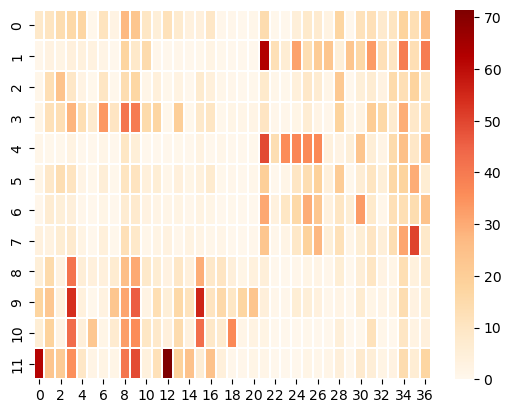

In [12]:
from sklearn.cluster import SpectralBiclustering

# Cluster the Dravnieks data
percept = dravnieks_filtered.to_numpy()
model = SpectralBiclustering(n_clusters=2, random_state=0)
model.fit(percept)

# Permute rows and columns
fit_data = percept[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

# Show the clustered Dravnieks data
plt.plot(figsize=(50,10))
sns.heatmap(data=fit_data, cmap='OrRd', linewidths=0.3)

<AxesSubplot:>

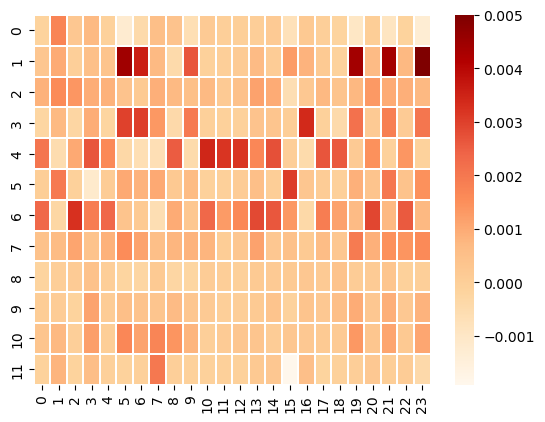

In [11]:
# Apply the same row permutations to the Chae glomerular data. 
glom = chae_filtered.to_numpy()
glom_shuff = glom[np.argsort(model.row_labels_)]
sns.heatmap(glom_shuff, cmap='OrRd', linewidths=0.3, vmax=.005)

The final biclustering results can be observed below: 

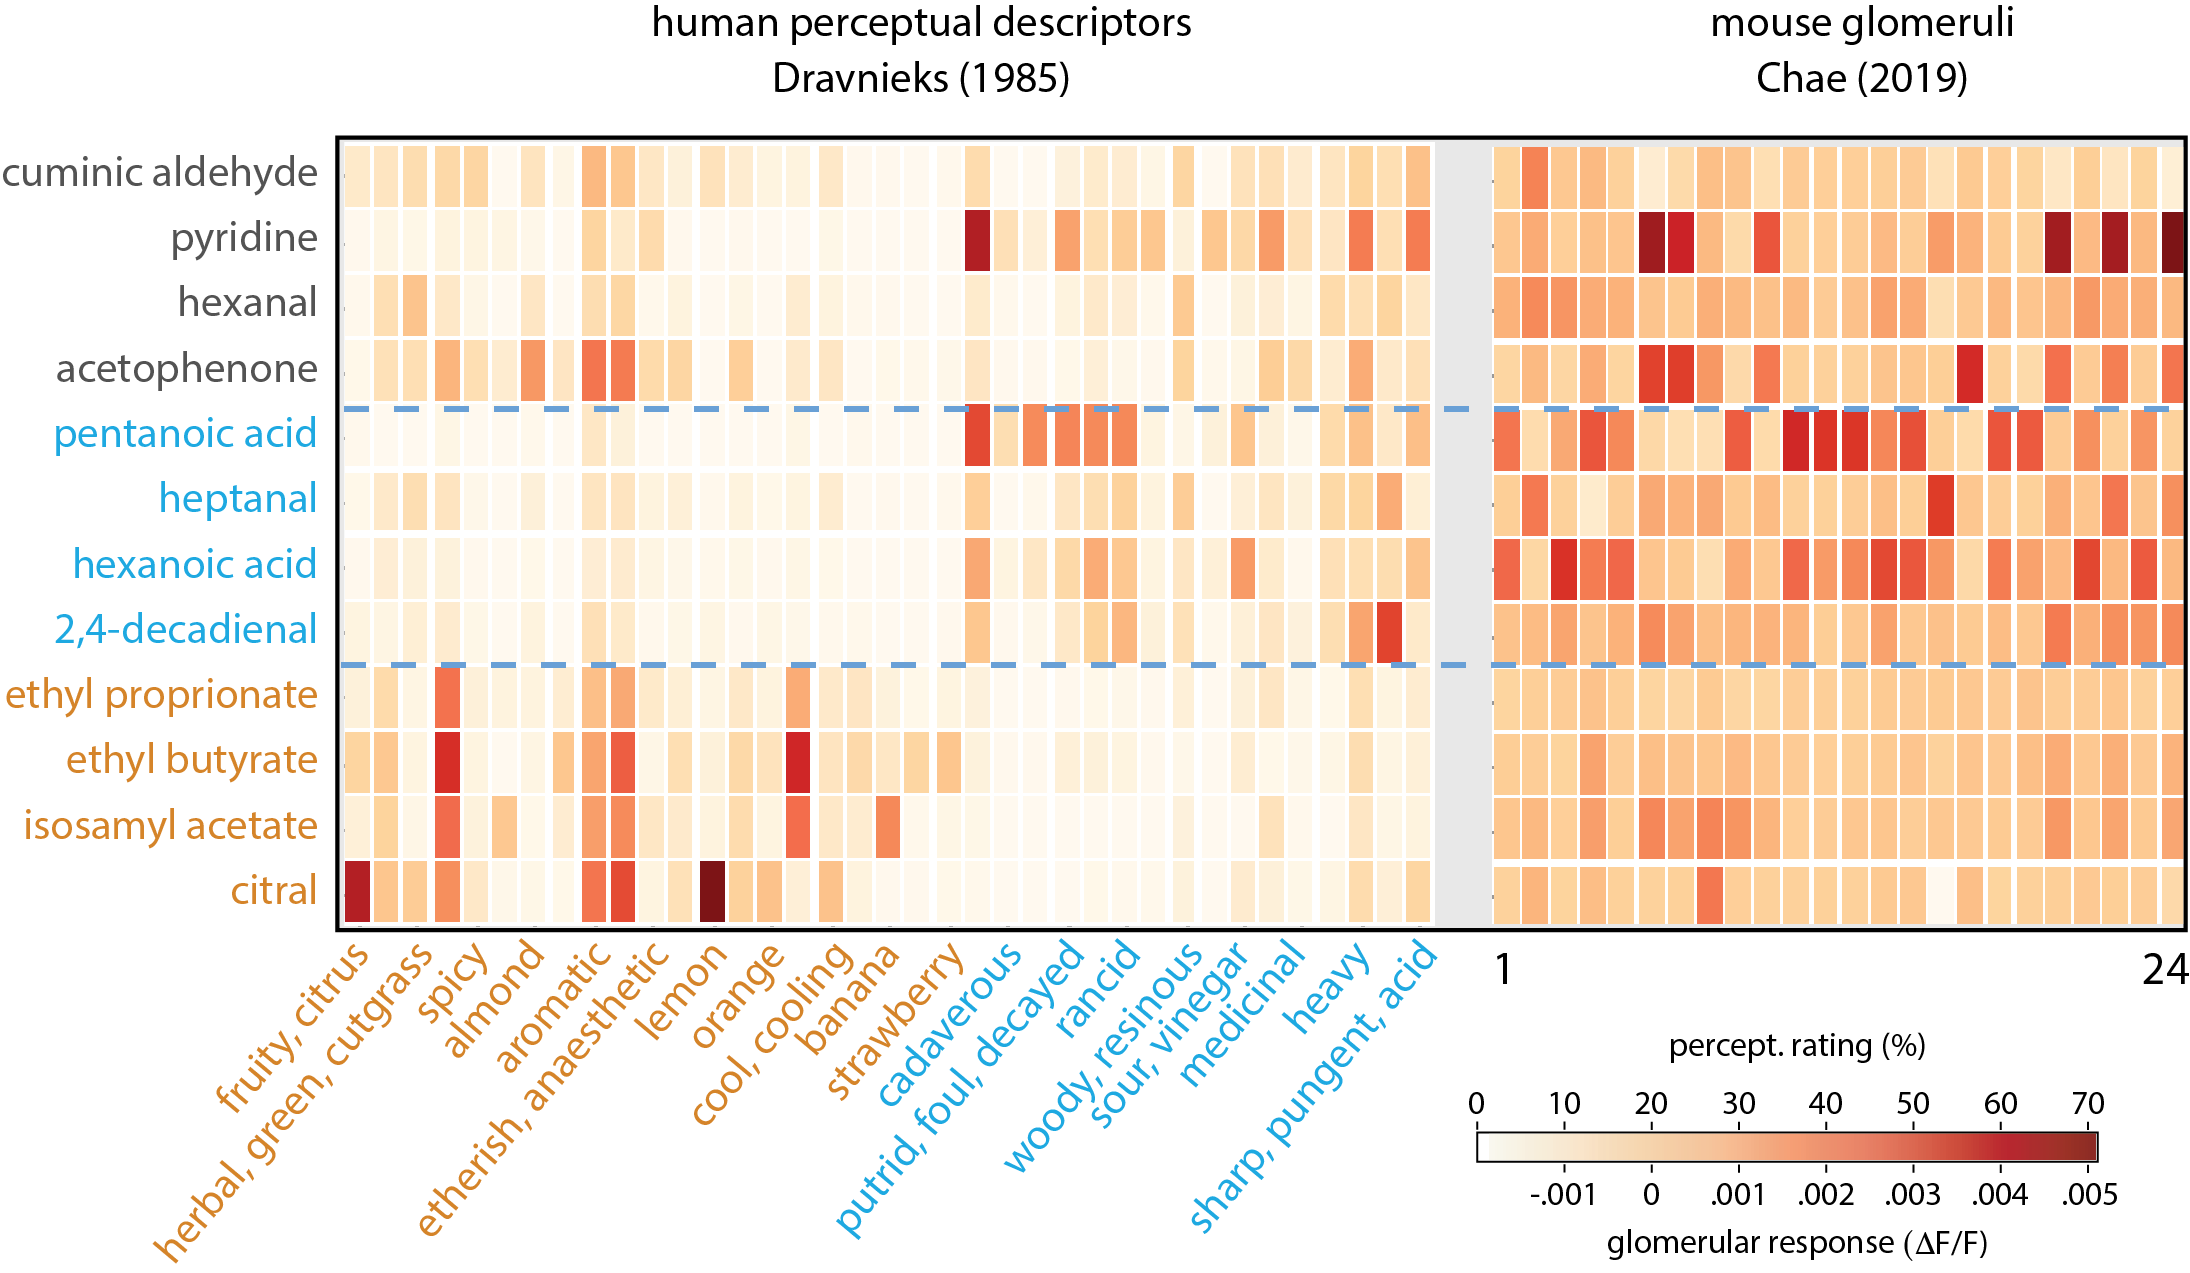

In [14]:
Image(filename='case_study.png', width=800) 